# Homework 3

Deadline: May 19, 2024

In [27]:
import os
import sys
import warnings
import matplotlib
import numpy as np
import pandas as pd
from typing import Sequence
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from matplotlib.axes import Axes
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

np.random.seed(42)
matplotlib.rcParams['font.family'] = 'SimHei'
matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings("ignore")
path = os.path.dirname(os.getcwd())
sys.path.append(path)
fig_folder = "Homework_3"

# 用于获取文件以及图片的保存路径的，请自行替换路径
from common.filesio import FilesIO
from common.figsio import FiguresIO

1. The classic Olivetti faces dataset contains 400 grayscale 64 x 64-pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the sklearn.datasets.fetch_olivetti_faces() function, then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set. Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in our lecture). Visualize the clusters: do you see similar faces in each cluster?

In [2]:
# 获取全部对应的数据集并保存到本地
df = pd.DataFrame(fetch_olivetti_faces().data)
df["target"] = fetch_olivetti_faces().target
df.to_csv(FilesIO.getHomeworkData("olivetti_faces.csv"), index=False)

save figure take_a_look...


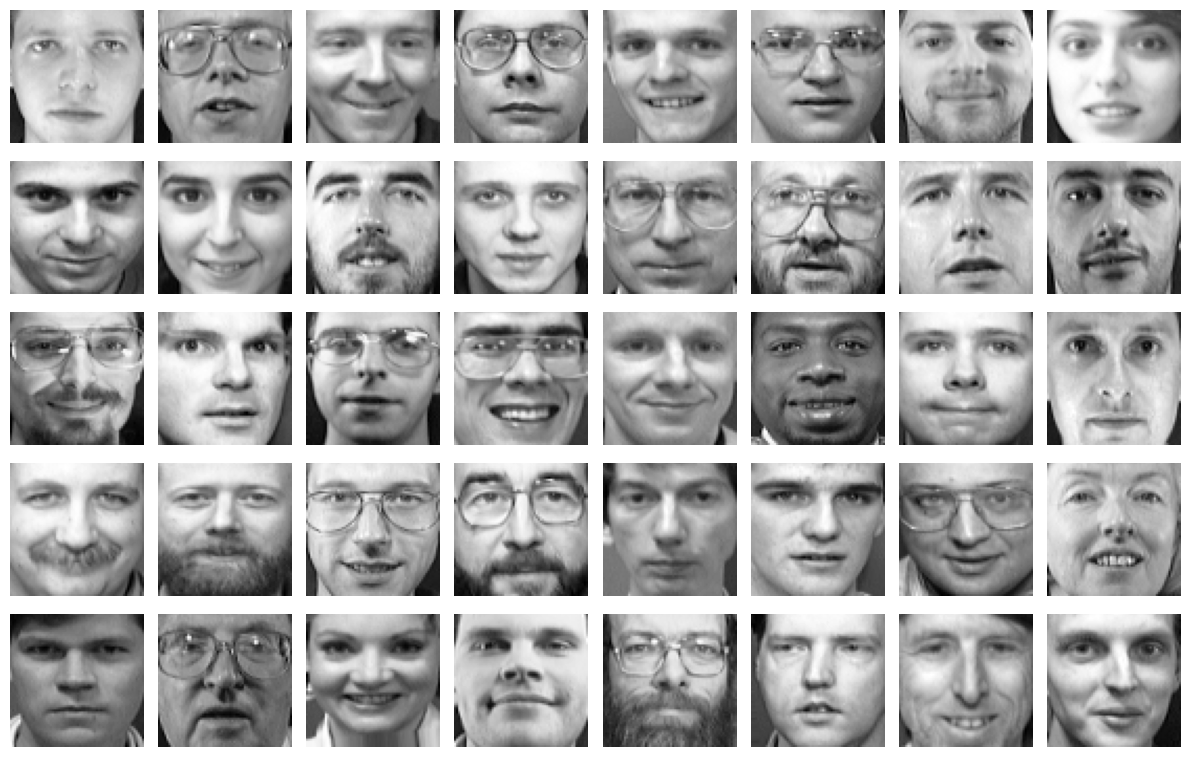

In [3]:
# 大致看一看每张图片的样子
row_data = fetch_olivetti_faces()
images = row_data["images"]
every_one, i = [], 0
while i < len(images):
    every_one.append(images[i])
    i += 10
fig, ax = plt.subplots(5, 8, figsize=(12, 8), dpi=100)
for i, axi in enumerate(ax.flat):
    axi.imshow(every_one[i], cmap="gray")
    axi.axis("off")
    plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0)
plt.tight_layout()
FiguresIO.saveFigures("take_a_look", fig_folder)
plt.show()

In [4]:
data = pd.read_csv(FilesIO.getHomeworkData("olivetti_faces.csv"))

# 提取特征和标签
X, y = data.drop(columns=['target']), data['target']

# 分层拆分数据集：训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

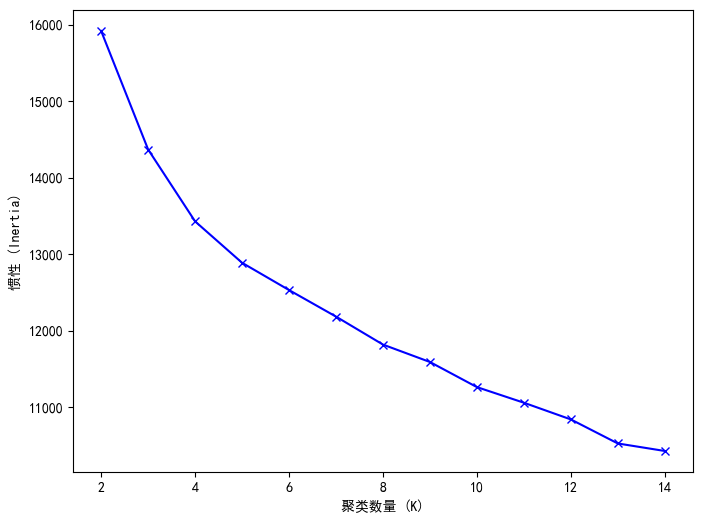

In [17]:
# 确定适当的聚类数量，使用肘部法则找到最佳的K值
inertia = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100) 
ax.plot(K, inertia, 'bx-')
ax.set_xlabel('聚类数量 (K)')
ax.set_ylabel('惯性 (Inertia)')
plt.show()

In [9]:
# 选择12个聚类进行K-Means聚类
kmeans = KMeans(n_clusters=12, random_state=42)
kmeans.fit(X_train)

# 预测聚类标签
train_labels = kmeans.labels_
val_labels = kmeans.predict(X_val)
test_labels = kmeans.predict(X_test)

In [14]:
# 定义函数将一维图像数据重构为二维
def plot_images(
        images: list, labels: list, n_rows: int=3, n_cols: int=4
    ) -> Axes:
    _, ax = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    for i, (image, label) in enumerate(zip(images, labels)):
        ax[i // n_cols, i % n_cols].imshow(image.reshape(64, 64), cmap='gray')
        ax[i // n_cols, i % n_cols].set_title(f'Cluster {label}')
        ax[i // n_cols, i % n_cols].axis('off')
    plt.tight_layout()
    return ax

save figure cluster_visualize...


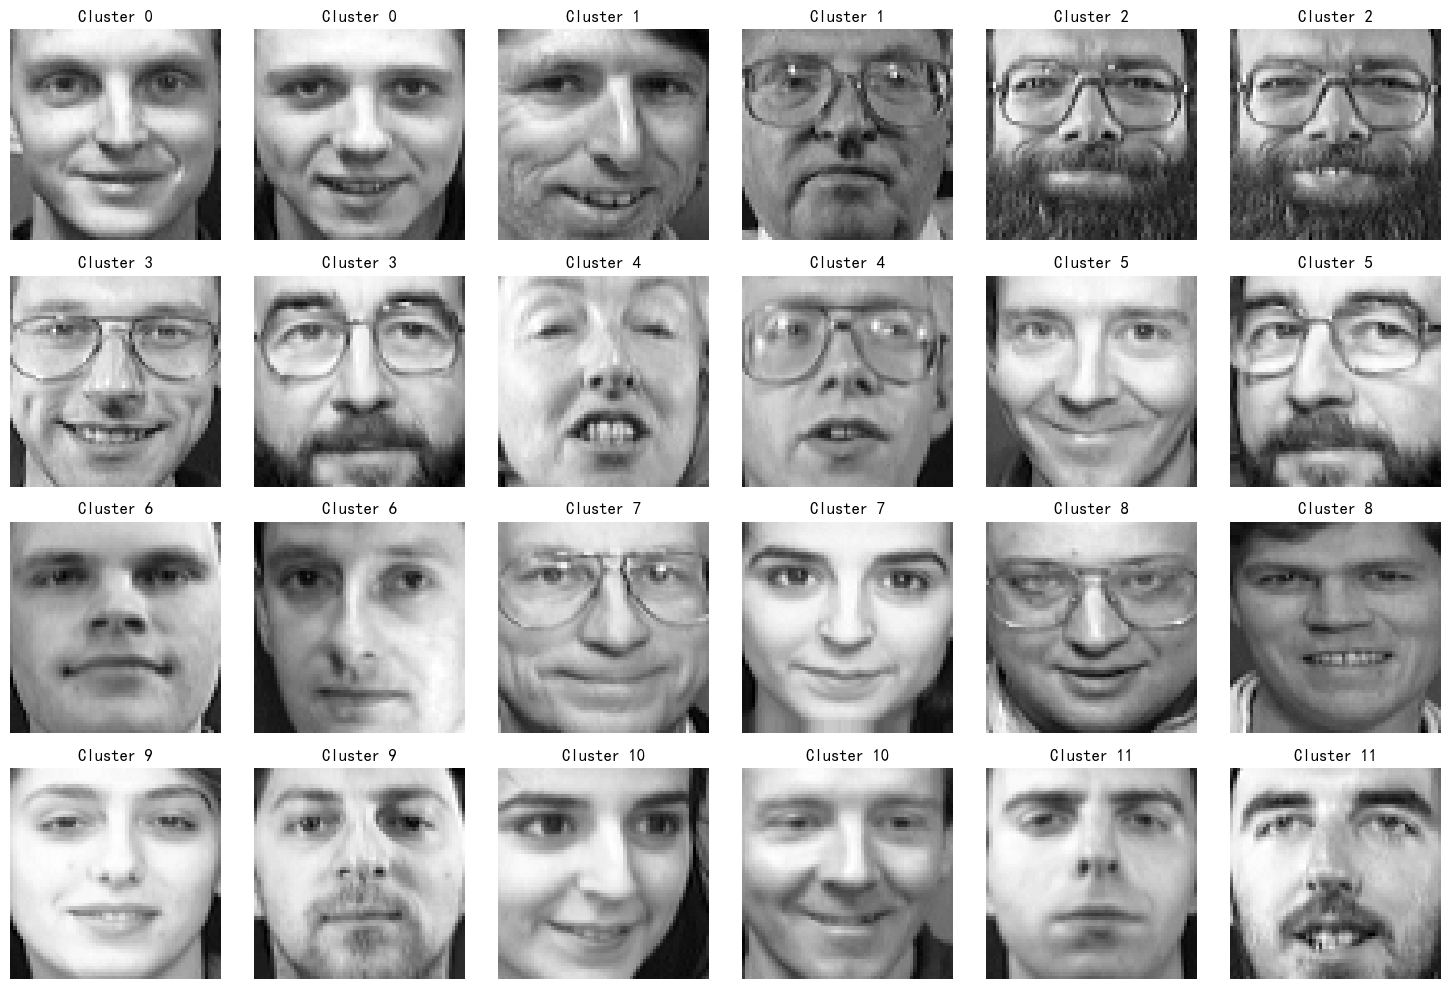

In [18]:
# 修改样本数量和显示布局，确保不超出限制
n_samples = 2
n_rows = 4
n_cols = 6

selected_images = []
selected_labels = []

for cluster in np.unique(train_labels):
    cluster_indices = np.where(train_labels == cluster)[0]
    if len(cluster_indices) >= n_samples:
        selected_indices = np.random.choice(cluster_indices, n_samples, replace=False)
    else:
        selected_indices = cluster_indices
    selected_images.extend(X_train.iloc[selected_indices].values)
    selected_labels.extend([cluster] * len(selected_indices))

# 可视化选取的图像
ax = plot_images(selected_images, selected_labels, n_rows, n_cols)
FiguresIO.saveFigures("cluster_visualize", fig_folder)
plt.show()

2. Continuing with the Olivetti faces dataset, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set. Next, use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set. Search for the number of clusters that allows the classifier to get the best performance: what performance can you reach? What if you append the features from the reduced set to the original features (again, searching for the best number of clusters?

In [21]:
# 训练初始分类器(使用随机森林)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# 在验证集上进行评估
y_val_pred = clf.predict(X_val)
initial_accuracy = accuracy_score(y_val, y_val_pred)

print("初始训练:", initial_accuracy)

初始训练: 0.925


In [23]:
# 定义函数将降维后的特征附加到原始特征上，并搜索最佳聚类数量
def evaluate_combined_features(
        X_train: Sequence, X_val: Sequence, 
        y_train: Sequence, y_val: Sequence, cluster_range: list
    ) -> tuple[int, float, list[tuple[int, float]]]:
    
    best_k = 0
    best_accuracy = 0
    results = []
    
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_train)
        
        X_train_kmeans = kmeans.transform(X_train)
        X_val_kmeans = kmeans.transform(X_val)
        
        # 将降维后的特征附加到原始特征上
        X_train_combined = pd.concat(
            [pd.DataFrame(X_train_kmeans), X_train.reset_index(drop=True)], axis=1
        )
        X_train_combined.columns = X_train_combined.columns.astype(str)
        X_val_combined = pd.concat(
            [pd.DataFrame(X_val_kmeans), X_val.reset_index(drop=True)], axis=1
        )
        X_val_combined.columns = X_val_combined.columns.astype(str)
        
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_train_combined, y_train)
        y_val_pred = clf.predict(X_val_combined)
        accuracy = accuracy_score(y_val, y_val_pred)
        
        results.append((k, accuracy))
        if (accuracy > best_accuracy):
            best_accuracy = accuracy
            best_k = k
    
    return best_k, best_accuracy, results

# 搜索最佳聚类数量
cluster_range = range(5, 30, 5)
best_combined_k, best_combined_accuracy, combined_results\
= evaluate_combined_features(X_train, X_val, y_train, y_val, cluster_range)

print(f"Best K: {best_combined_k}")
print(f"Best Accuracy: {best_combined_accuracy}")
print(f"Results: {combined_results}")

Best K: 25
Best Accuracy: 0.925
Results: [(5, 0.9125), (10, 0.9125), (15, 0.9), (20, 0.9125), (25, 0.925)]


3. Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the algorithm, you should probably reduce the data set dimensionality (e.g., PCA, preserving 99% of the variance). Use the model to generate some new faces (using the sample() method), and visualize them (if you used PCA, you will need to use its inverse transform() method). Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the score_samples() method for normal images and for anomalies).

In [25]:
# 使用PCA降维数据集，保留99%的方差
pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

save figure New_faces...


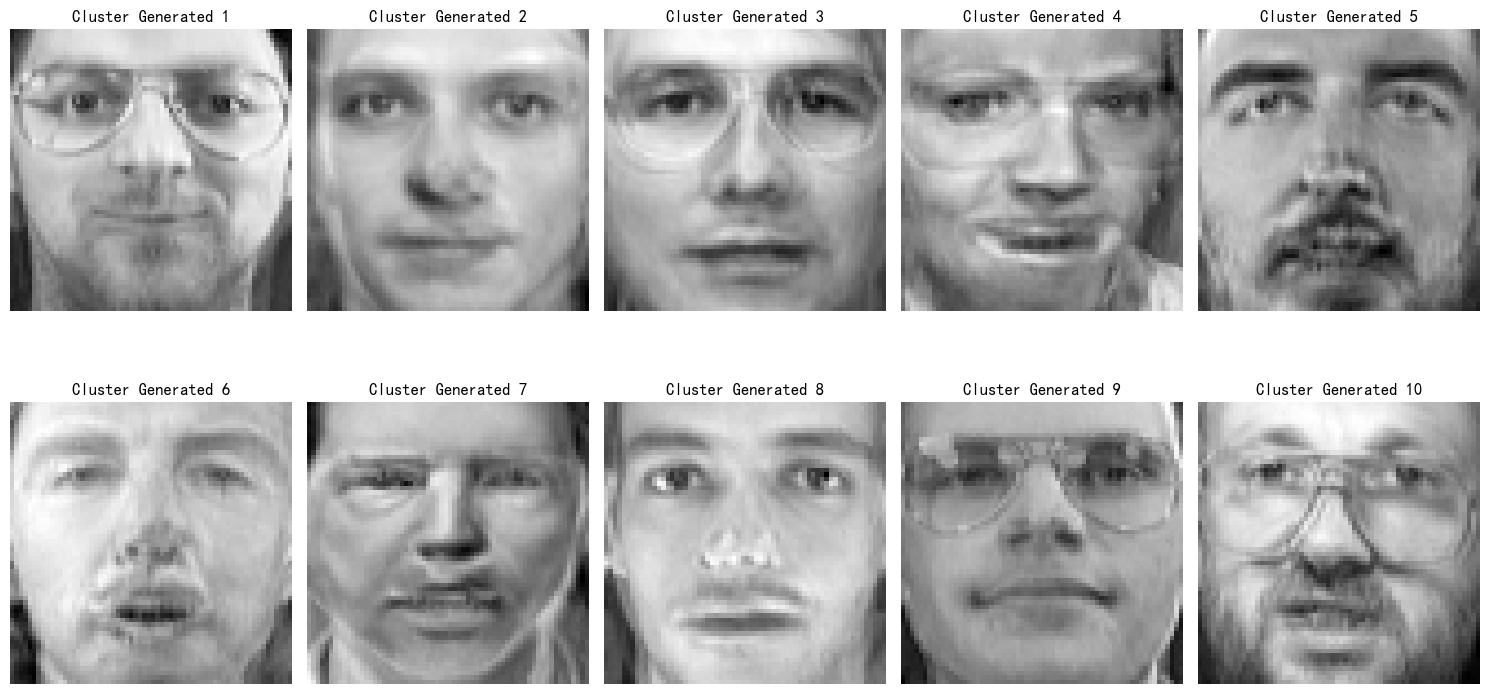

In [26]:
# 训练高斯混合模型（GMM）
gmm = GaussianMixture(n_components=40, random_state=42)
gmm.fit(X_train_pca)
# 使用GMM生成一些新的面孔图像
n_samples = 10
generated_samples, _ = gmm.sample(n_samples)
generated_images = pca.inverse_transform(generated_samples)

# 可视化生成的面孔图像
ax = plot_images(
    generated_images, 
    labels=[f'Generated {i+1}' for i in range(n_samples)], n_rows=2, n_cols=5
)
FiguresIO.saveFigures("New_faces", fig_folder)
plt.show()

In [28]:
# 定义函数修改图像
def modify_images(images: Sequence) -> np.ndarray:
    
    modified_images = []
    for image in images:
        image = image.reshape(64, 64)
        # 旋转图像
        rotated_image = rotate(image, angle=45, reshape=False)
        # 翻转图像
        flipped_image = np.fliplr(image)
        # 变暗图像
        darkened_image = image * 0.5
        modified_images.extend([rotated_image, flipped_image, darkened_image])
    return np.array(modified_images).reshape(-1, 64 * 64)

save figure Modified Images...


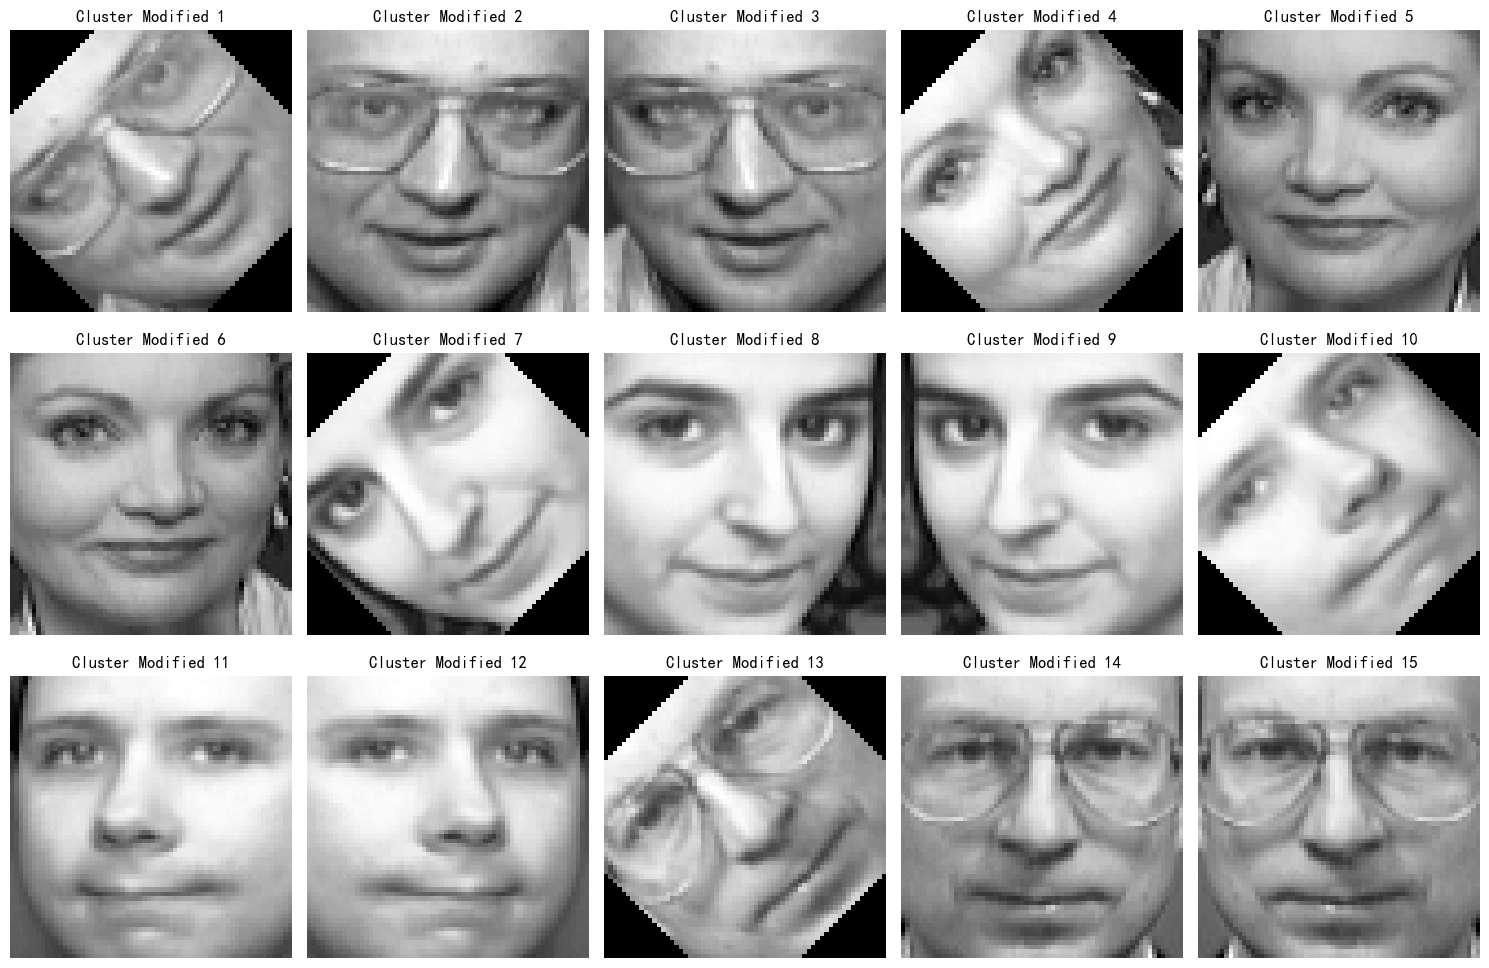

正常图像的分数：
图像1的分数：-5131936.589430682
图像2的分数：-3226133.736303876
图像3的分数：-17348786.863057613
图像4的分数：-1610992.565686162
图像5的分数：-5000324.0887165535
修改后图像的分数：
修改图像1的分数：-51267688.415465
修改图像2的分数：-10693536.208776254
修改图像3的分数：-36008546.227767035
修改图像4的分数：-72099623.07114059
修改图像5的分数：-17351539.126576643
修改图像6的分数：-24314658.48257043
修改图像7的分数：-86002149.81340234
修改图像8的分数：-6428390.232058087
修改图像9的分数：-26838686.710956626
修改图像10的分数：-84270237.98302016
修改图像11的分数：-5437469.898361231
修改图像12的分数：-12670762.788489891
修改图像13的分数：-57501427.34065906
修改图像14的分数：-8862109.732149068
修改图像15的分数：-28103829.302450348


In [29]:
# 从验证集中选择一些图像进行修改
n_val_samples = 5
selected_val_images = X_val.sample(n_val_samples, random_state=42).values
# 生成修改后的图像
modified_images = modify_images(selected_val_images)
# 降维修改后的图像
modified_images_pca = pca.transform(modified_images)
# 计算正常图像和异常图像的分数
normal_scores = gmm.score_samples(pca.transform(selected_val_images))
modified_scores = gmm.score_samples(modified_images_pca)
# 可视化修改后的图像
ax = plot_images(
    modified_images, labels=[f'Modified {i+1}' for i in range(len(modified_images))], 
    n_rows=3, n_cols=5
)
FiguresIO.saveFigures("Modified Images", fig_folder)
plt.show()

# 返回正常图像和异常图像的分数
# 从分数可以看出，修改后的图像分数明显低于正常图像，表示模型能够检测到这些异常图像
print("正常图像的分数：")
for i in range(len(normal_scores)):
    print(f"图像{i+1}的分数：{normal_scores[i]}")
print("修改后图像的分数：")
for i in range(len(modified_scores)):
    print(f"修改图像{i+1}的分数：{modified_scores[i]}")


4. Some dimensionality reduction techniques can also be used for anomaly detection. For example, take the Olivetti faces dataset and reduce it with PCA, presering 99% of the variance. Then compute the reconstruction error for each image. Next, take some of the modified images you built in the previous exercise, and look at their reconstruction error: notice how much larger the reconstruction error is. If you plot a reconstructed image, you will see why: it tries to reconstruct a normal face.

save figure Reconstructed Images...


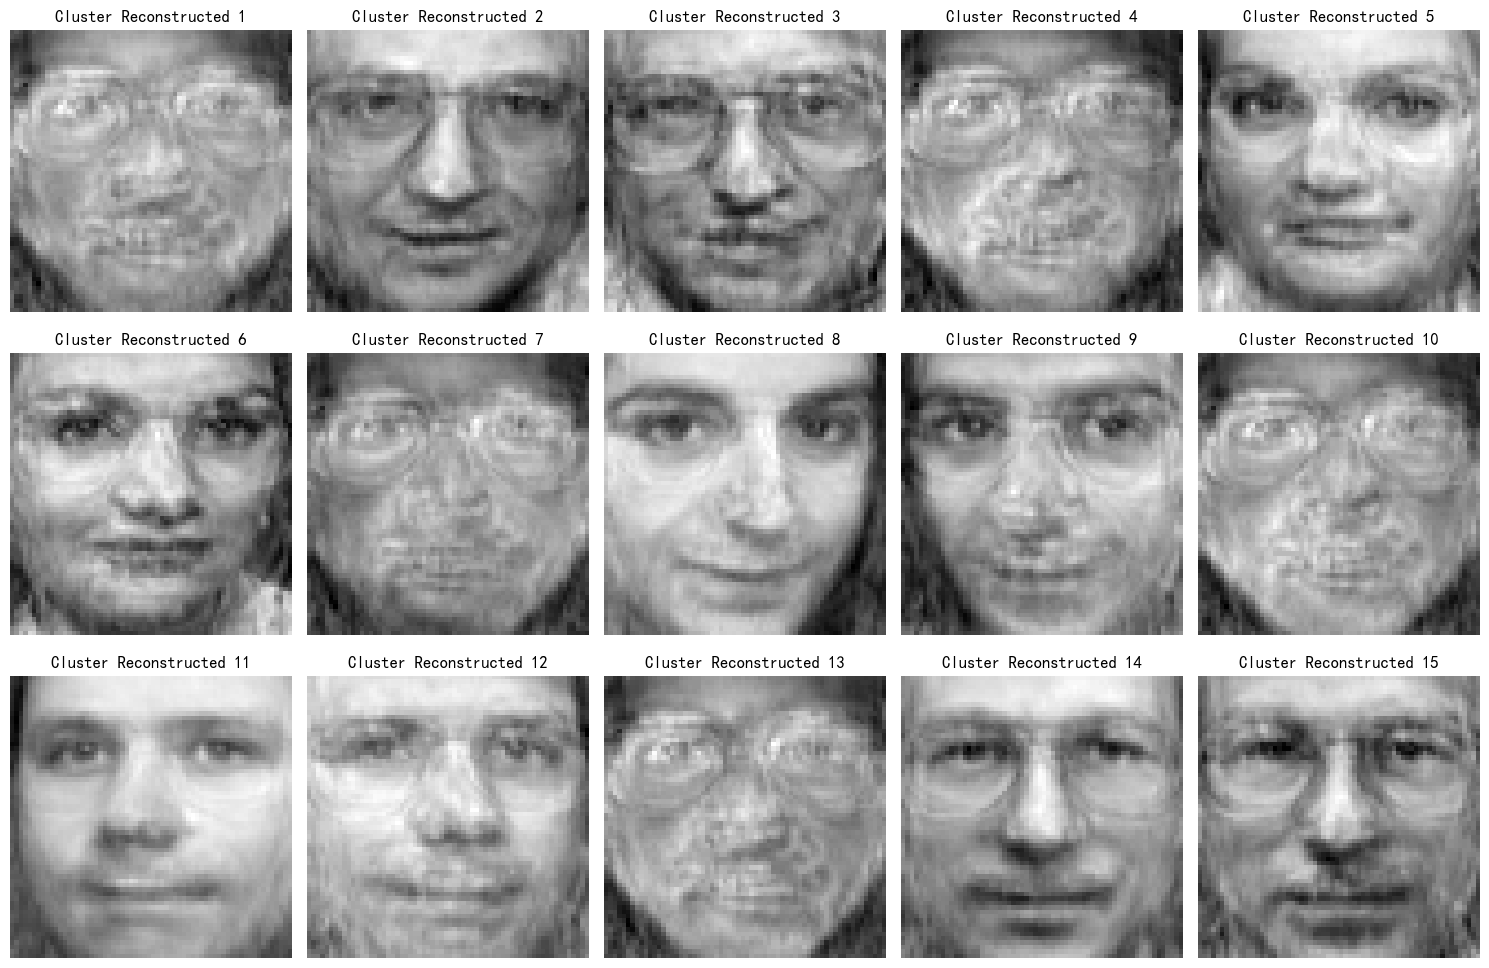

修改后图像的重建误差:
修改图像1: 0.0138
修改图像2: 0.0024
修改图像3: 0.0009
修改图像4: 0.0179
修改图像5: 0.0040
修改图像6: 0.0010
修改图像7: 0.0241
修改图像8: 0.0030
修改图像9: 0.0014
修改图像10: 0.0174
修改图像11: 0.0012
修改图像12: 0.0006
修改图像13: 0.0174
修改图像14: 0.0027
修改图像15: 0.0009


In [32]:
# 使用PCA对修改后的图像进行降维
modified_images_pca = pca.transform(modified_images)
# 使用PCA的逆变换重建这些图像
reconstructed_images = pca.inverse_transform(modified_images_pca)
# 计算重建误差
reconstruction_errors = np.mean((modified_images - reconstructed_images) ** 2, axis=1)
# 可视化重建图像
ax = plot_images(
    reconstructed_images, 
    labels=[f'Reconstructed {i+1}' for i in range(len(reconstructed_images))], 
    n_rows=3, n_cols=5
)
FiguresIO.saveFigures("Reconstructed Images", fig_folder)
plt.show()

print("修改后图像的重建误差:")
for i, error in enumerate(reconstruction_errors):
    print(f"修改图像{i+1}: {error:.4f}")